# 01_MA_AR — UPDATED (2025-10-23 07:40)
Denne notatboken er en **oppdatert** versjon av filen du lastet opp. 
Jeg har **markert alle konkrete endringer** med: `# >>> CHANGE:`

Endringene sikrer at:
- AR og MA er **separate, enkle modeller** (ingen ARMA/ARIMA).
- **AR**: stasjonaritet håndheves og **konstant** (`trend='c'`) er inkludert.
- **MA**: invertibilitet håndheves, konsistent evaluering i **nivå** (med bias-korreksjon).
- Unngår å blande **logg** og **nivå** i evaluering/plot.
- AIC-grid bruker riktige constraints.


In [2]:
# --- Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [3]:
# --- Helper functions
def residual_diagnostics(resid, lags=24):
    """Basic diagnostics for ε_t: mean, std, Ljung–Box p-value at given lag."""
    r = pd.Series(resid).dropna()
    lb = acorr_ljungbox(r, lags=[lags], return_df=True)
    return {
        "eps_mean": float(r.mean()),
        "eps_std": float(r.std(ddof=1)),
        f"LjungBox_p(lag{lags})": float(lb["lb_pvalue"].iloc[-1]),
    }

def mae(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

def mape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = np.where(y == 0, np.nan, y)
    return float(np.nanmean(np.abs((y - yhat) / denom)) * 100.0)

def adf_p(x):
    x = pd.Series(x).dropna()
    return adfuller(x, autolag="AIC")[1]


In [4]:
# --- Data: train/test split already prepared as CSVs
train = pd.read_csv("train_data.csv", parse_dates=["date"]).set_index("date").sort_index()
test  = pd.read_csv("test_data.csv",  parse_dates=["date"]).set_index("date").sort_index()

print(f"Train: {train.index.min().date()} → {train.index.max().date()}  rows={len(train)}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}   rows={len(test)}")

# Work on log-volume series (variance stabilization)
train['log_volume'] = np.log(train['volume_all'])
test['log_volume']  = np.log(test['volume_all'])

V_tr = train['log_volume']
V_te = test['log_volume']


Train: 2004-01-01 → 2022-12-30  rows=4957
Test:  2023-01-02  → 2025-10-08   rows=723


ADF p-value (raw volume): 0.17170
ADF p-value (log volume): 0.14445


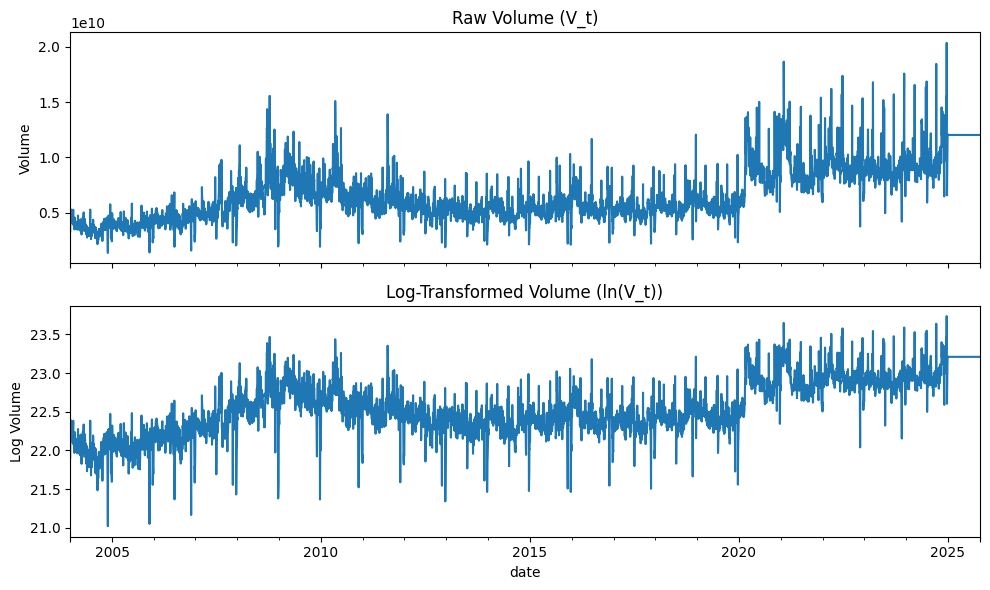

In [5]:
# --- Stationarity diagnostics on full (merged) data
df_full = pd.read_csv("merged_volume_volatility.csv", parse_dates=["date"]).set_index("date").sort_index()
df_full['log_volume'] = np.log(df_full['volume_all'])

p_raw = adfuller(df_full['volume_all'].dropna(), autolag="AIC")[1]
p_log = adfuller(df_full['log_volume'].dropna(), autolag="AIC")[1]
print(f"ADF p-value (raw volume): {p_raw:.5f}")
print(f"ADF p-value (log volume): {p_log:.5f}")

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
df_full['volume_all'].plot(ax=ax[0])
ax[0].set_title("Raw Volume (V_t)")
ax[0].set_ylabel("Volume")
df_full['log_volume'].plot(ax=ax[1])
ax[1].set_title("Log-Transformed Volume (ln(V_t))")
ax[1].set_ylabel("Log Volume")
plt.tight_layout(); plt.show()


## MA(q) — enkel MA på logg-serien (med riktig evaluering i nivå)

/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.4764      0.005   4138.519      0.000      22.466      22.487
ma.L1          0.6664      0.009     70.825      0.000       0.648       0.685
sigma2         0.0525      0.001     64.051      0.000       0.051       0.054
Diagnostics MA(q): {'eps_mean': 0.00430046926744306, 'eps_std': 0.38625087103369304, 'LjungBox_p(lag24)': 0.0}
MA(q=1)  MAE(level): 4120642610.395


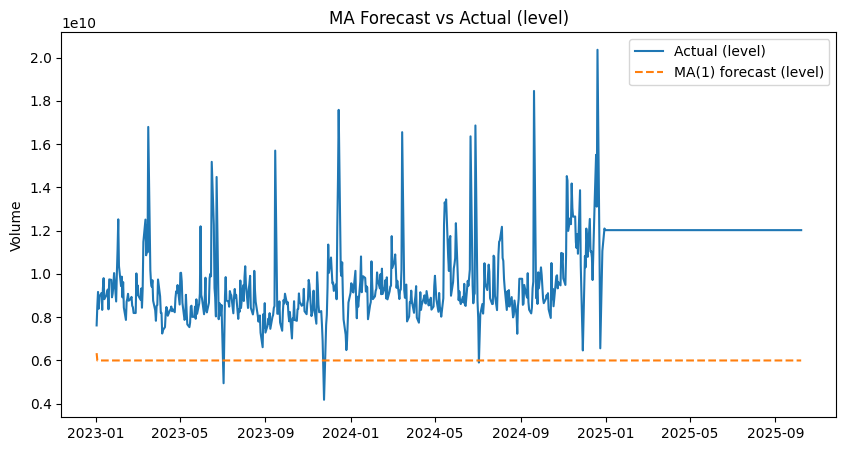

In [6]:
# --- MA(q) model on log-volume
q = 1  # order of the MA(q)

ma_model = sm.tsa.SARIMAX(
    V_tr,
    order=(0, 0, q),        # MA(q)
    trend='c',              # include constant
    enforce_stationarity=False,
    enforce_invertibility=True  # >>> CHANGE: enforce invertibility for MA
)
ma_res = ma_model.fit(disp=False)
print(ma_res.summary().tables[1])

# Forecast for the full test horizon (LOG scale)
fc_ma = ma_res.get_forecast(steps=len(V_te))
sf_ma = fc_ma.summary_frame()
mu_ma = sf_ma['mean']
sigma2_ma = sf_ma['mean_se']**2

# Back-transform to LEVEL with bias correction
# >>> CHANGE: evaluate in LEVEL scale consistently
ma_level = np.exp(mu_ma + 0.5 * sigma2_ma)
y_te_level = np.exp(V_te)

# Diagnostics + metrics
diag_ma = residual_diagnostics(ma_res.resid, lags=24)
print("Diagnostics MA(q):", diag_ma)
print(f"MA(q={ma_res.model_orders['ma']})  MAE(level): {mae(y_te_level, ma_level):.3f}")

# Plot (LEVEL scale)
plt.figure(figsize=(10,5))
plt.plot(V_te.index, y_te_level.values, label="Actual (level)")
plt.plot(V_te.index, ma_level.values, label=f"MA({q}) forecast (level)", linestyle="--")
plt.title("MA Forecast vs Actual (level)")
plt.ylabel("Volume"); plt.legend(); plt.show()


## AR(p) — enkel AR på logg-serien (med konstant & stasjonaritetskrav)

/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8644      0.117     24.433      0.000       2.635       3.094
ar.L1          0.8726      0.005    167.137      0.000       0.862       0.883
sigma2         0.0248      0.000    102.718      0.000       0.024       0.025
Diagnostics AR(p): {'eps_mean': 8.831850092391291e-05, 'eps_std': 0.15762282963198856, 'LjungBox_p(lag24)': 5.475849471814716e-85}
AR(p=1)  MAE(level): 4033767040.126


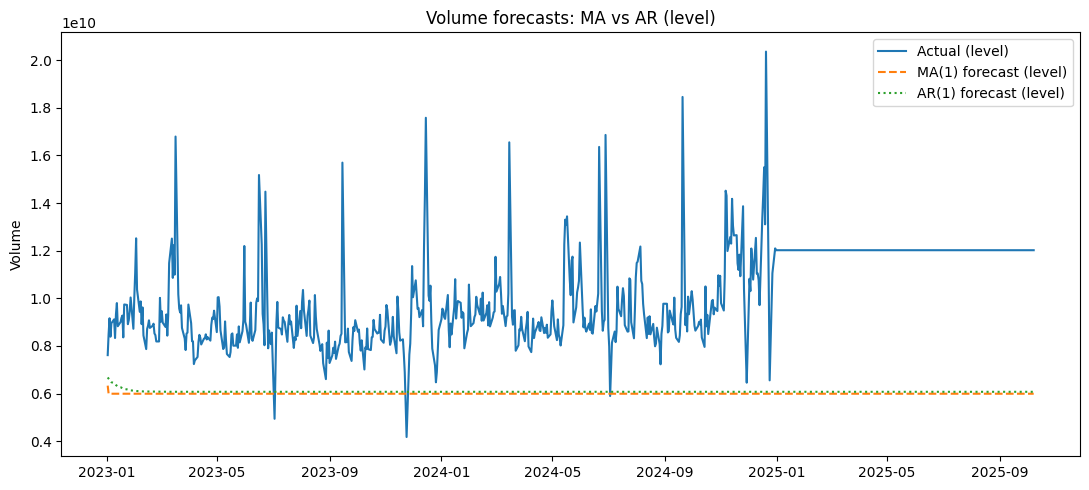

In [7]:
# --- AR(p) model on log-volume
p = 1

ar_model = sm.tsa.SARIMAX(
    V_tr,
    order=(p, 0, 0),            # AR(p)
    trend='c',                  # >>> CHANGE: include constant c
    enforce_stationarity=True,  # >>> CHANGE: enforce stationarity for AR
    enforce_invertibility=False # (irrelevant for pure AR)
)
ar_res = ar_model.fit(disp=False)
print(ar_res.summary().tables[1])

# Forecast (LOG) and back-transform to LEVEL with bias correction
fc_ar = ar_res.get_forecast(steps=len(V_te))
sf_ar = fc_ar.summary_frame()
mu_ar = sf_ar['mean']
sigma2_ar = sf_ar['mean_se']**2
ar_level = np.exp(mu_ar + 0.5 * sigma2_ar)  # >>> CHANGE: consistent LEVEL evaluation

# Diagnostics + metrics
diag_ar = residual_diagnostics(ar_res.resid, lags=24)
print("Diagnostics AR(p):", diag_ar)
print(f"AR(p={ar_res.model_orders['ar']})  MAE(level): {mae(y_te_level, ar_level):.3f}")

# Plot both (LEVEL)
plt.figure(figsize=(11,5))
plt.plot(V_te.index, y_te_level.values, label="Actual (level)")
plt.plot(V_te.index, ma_level.values, label=f"MA({q}) forecast (level)", linestyle="--")
plt.plot(V_te.index, ar_level.values, label=f"AR({p}) forecast (level)", linestyle=":")
plt.title("Volume forecasts: MA vs AR (level)")
plt.ylabel("Volume"); plt.legend(); plt.tight_layout(); plt.show()


## Modellvalg med AIC — korrigerte constraints for AR og MA

In [8]:
def aic_grid_ma(y, q_max=4):
    rows = []
    for q in range(1, q_max + 1):
        try:
            r = sm.tsa.SARIMAX(
                y, order=(0, 0, q),
                trend='c',                         # >>> CHANGE: include constant
                enforce_stationarity=False,
                enforce_invertibility=True         # >>> CHANGE: enforce invertibility for MA
            ).fit(disp=False)
            rows.append((q, r.aic))
        except Exception:
            rows.append((q, np.inf))
    return pd.DataFrame(rows, columns=["q", "AIC"]).sort_values("AIC")

def aic_grid_ar(y, p_max=4):
    rows = []
    for p in range(1, p_max + 1):
        try:
            r = sm.tsa.SARIMAX(
                y, order=(p, 0, 0),
                trend='c',                         # >>> CHANGE: include constant
                enforce_stationarity=True,         # >>> CHANGE: enforce stationarity for AR
                enforce_invertibility=False
            ).fit(disp=False)
            rows.append((p, r.aic))
        except Exception:
            rows.append((p, np.inf))
    return pd.DataFrame(rows, columns=["p", "AIC"]).sort_values("AIC")

display(aic_grid_ma(V_tr, q_max=4))
display(aic_grid_ar(V_tr, p_max=4))


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

,q,AIC
3,4,-3154.868973
2,3,-2881.207731
1,2,-2088.193560
0,1,-538.107029


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

,p,AIC
3,4,-4693.777723
2,3,-4578.752836
1,2,-4496.885937
0,1,-4253.327692


## Sammenlikningstabell — evaluering i nivå (konsistent)

In [ ]:
scores = pd.DataFrame({
    "MAE(level)":  [mae(y_te_level, ma_level), mae(y_te_level, ar_level)],
    "MAPE(level)": [mape(y_te_level, ma_level), mape(y_te_level, ar_level)],
}, index=[f"MA(q={ma_res.model_orders['ma']})", f"AR(p={ar_res.model_orders['ar']})"])
scores


## (Valgfritt) Når serien ikke er stasjonær: AR/MA på Δlog
Hvis ADF fortsatt indikerer ikke-stasjonaritet, kan du bruke **enkle AR/MA** på første differanse av logg-serien (vekstrater). 
Dette er *fortsatt separate AR/MA-modeller*, men på en stasjonær transformasjon.


In [ ]:
# >>> OPTIONAL: use Δlog neccessarry
train['dlog'] = train['log_volume'].diff()
test['dlog']  = test['log_volume'].diff()
d_tr = train['dlog'].dropna()
d_te = test['dlog'].dropna()
print("ADF p (Δlog):", adfuller(d_tr, autolag="AIC")[1])

# AR on Δlog
ar_d = sm.tsa.SARIMAX(d_tr, order=(1,0,0), trend='c',
                      enforce_stationarity=True, enforce_invertibility=False).fit(disp=False)
# MA on Δlog
ma_d = sm.tsa.SARIMAX(d_tr, order=(0,0,1), trend='c',
                      enforce_stationarity=False, enforce_invertibility=True).fit(disp=False)

h = len(d_te)
fc_ar_d = ar_d.get_forecast(steps=h).predicted_mean
fc_ma_d = ma_d.get_forecast(steps=h).predicted_mean

last_log = train['log_volume'].iloc[-1]
ar_log_path = last_log + fc_ar_d.cumsum()
ma_log_path = last_log + fc_ma_d.cumsum()
ar_level_d = np.exp(ar_log_path)
ma_level_d = np.exp(ma_log_path)

y_te_level_d = np.exp(test['log_volume'].iloc[:h])
print("AR(Δlog) MAE(level):", mae(y_te_level_d, ar_level_d))
print("MA(Δlog) MAE(level):", mae(y_te_level_d, ma_level_d))
